<div style="text-align: right">
    Chicago Crime Analysis <br>
    Project by <a href="https://github.com/David-ChunYin-Chan" target="_blank">David Chan</a>
</div>

# Introduction

This project delves into an in-depth analysis of Chicago Crime Data spanning the years 2001 to 2023. By leveraging various data manipulation and visualization techniques, we aim to uncover trends, patterns, and noteworthy insights within the dataset. The investigation encompasses a broad spectrum, including temporal trends, geographical variations, crime types, and the impact of external factors such as the COVID-19 pandemic. <br>
The findings presented in this project contribute to a comprehensive understanding of the dynamics and characteristics of criminal activities in Chicago over the specified time period.

# Acknowledgements

The Chicago Crime Data from 2001 to 2023 have been generously provided by the Chicago Police Department and the City of Chicago. This dataset is publicly available on Chicago Data Portal https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2/about_data with applicable terms.

Additionally, the population data by police district in Chicago have been contributed by the Chicago Recovery Plan, accessible at Chicago Recovery Plan - Geographies https://chirecoveryplan.com/geographies/#police-districts.

# 1: Data Collection

## 1.1: Chicago Crime Data

The data is extracted from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system. The dataset reflects reported incidents of crime (with the exception of murders where data exists for each victim) that occurred in the City of Chicago from 2001 to present, minus the most recent seven days.  In order to protect the privacy of crime victims, addresses are shown at the block level only and specific locations are not identified.

From the dataset source, there are 22 columns in the dataset:
- **ID**: Unique identifier for the record
- **Case Number**: The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.
- **Date**: Date when the incident occurred. this is sometimes a best estimate.
- **Block**: The partially redacted address where the incident occurred, placing it on the same block as the actual address.
- **IUCR**: The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e.
- **Primary Type**: The primary description of the IUCR code.
- **Description**: The secondary description of the IUCR code, a subcategory of the primary description.
- **Location Description**: Description of the location where the incident occurred.
- **Arrest**: Indicates whether an arrest was made.
- **Domestic**: Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.
- **Beat**: Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74.
- **District**: Indicates the police district where the incident occurred. See the districts at https://data.cityofchicago.org/d/fthy-xz3r.
- **Ward**: The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76.
- **Community Area**: Indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6.
- **FBI Code**: Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). See the Chicago Police Department listing of these classifications at http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html.
- **X Coordinate**: The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
- **Y Coordinate**: The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
- **Year**: Year the incident occurred.
- **Update On**: Date and time the record was last updated.
- **Latitude**: The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
- **Longitude**: The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
- **Location**: The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.

### 1.1.1: Create Table for the Dataset

```sql
CREATE TABLE crimes (
	id BIGSERIAL NOT NULL PRIMARY KEY,
	case_no VARCHAR(10),
	crime_date TIMESTAMP ,
	block VARCHAR(100),
	iucr VARCHAR(10),
	primary_type VARCHAR(50),
	description VARCHAR(100),
	location_description VARCHAR(500),
	arrest BOOLEAN,
	domestic BOOLEAN,
	beat VARCHAR(10),
	district VARCHAR(10),
	ward VARCHAR(10),
	community_area VARCHAR(10),
	fbi_code VARCHAR(10),
	x_coord FLOAT(16),
	y_coord FLOAT(16),
	crime_year SMALLINT,
	updated_on TIMESTAMP,
	lat FLOAT(16),
	long FLOAT(16),
	loc VARCHAR(100)
)
```

### 1.1.2: Insert Data

We imported the data into the table using pgAdmin, the graphical user interface for PostgreSQL. <br>
Now, let's take a look at a few rows from the table to get a quick overview of the dataset.

```sql
SELECT *
FROM crimes
LIMIT 5;
```

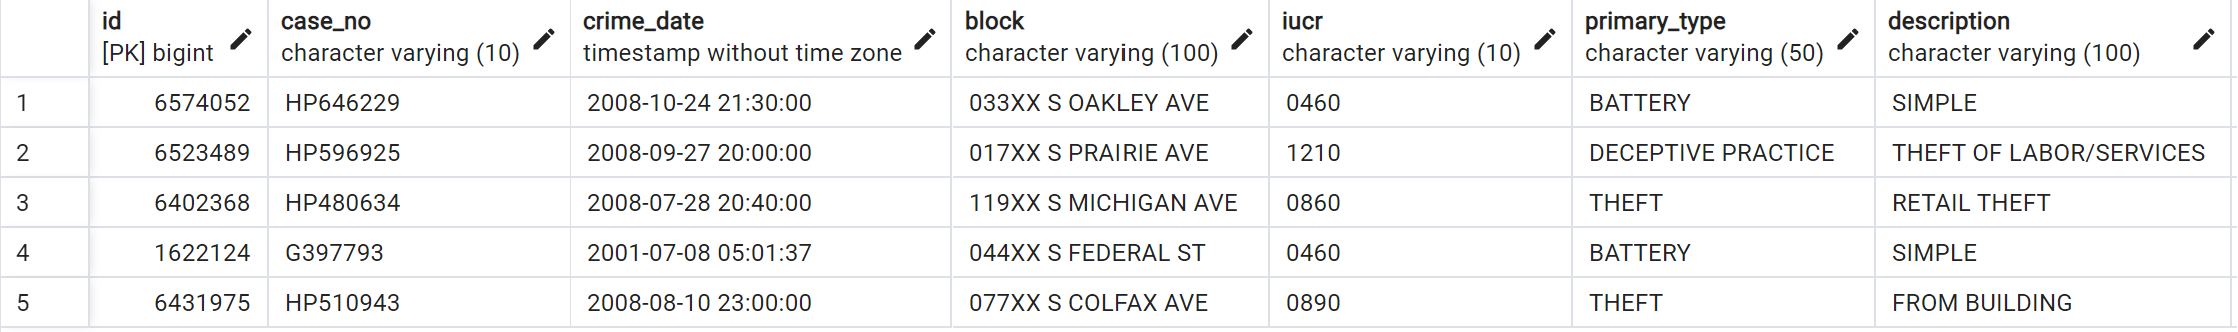

In [5]:
from IPython.display import display, Image
display(Image(filename="Screenshots/1.1.2_preview.png"))

## 1.2: Chicago Population Data

To compute crime rates, it is essential to possess population data categorized by police district — an element absent from the current dataset. Consequently, we have procured the requisite population information from https://chirecoveryplan.com/ through the implementation of web scraping techniques.

In [1]:
# Import necessary libraries for web scraping and data processing
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
DISTRICTS = [1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,22,24,25,31]
HEADERS = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.111 Safari/537.36'}

In [3]:
populations = {}
for district in DISTRICTS:
    url = f'https://chirecoveryplan.com/geography/police-district-{district}/'
    r = requests.get(url=url, headers=HEADERS)
    soup = BeautifulSoup(r.content, 'html5lib')
    pop = 0
    for i, text in enumerate(soup.find_all('table')[0].find_all('tbody')[0].find_all('td')):
        if i % 4 == 1:
            pop += int(text.text.replace(',',''))
    populations[district] = pop
populations = pd.DataFrame.from_dict(populations, orient='index', columns=['Population'])

In [6]:
populations.head()

,Population
1,108554
2,110811
3,92057
4,128467
5,81869


In [5]:
populations.to_excel('Population by District.xlsx')

## 1.3: Police District Geospatial Data

Additionally, in order to generate visual representations in the dashboard, it is imperative to acquire geographical boundaries for the 22 police districts. This specific data can be sourced from the following link: https://data.cityofchicago.org/Public-Safety/Boundaries-Police-Districts-current-/fthy-xz3r.

# 2: Data Cleaning

## 2.1: Primary Types of Crimes

Let's run the query below to explore the distribution of primary crime types.

```sql
SELECT primary_type, COUNT(primary_type) AS type_freq
FROM crimes
GROUP BY primary_type
ORDER BY primary_type;
```

We can see there are 37 distinct crime types, with some exhibiting similarities in meaning.

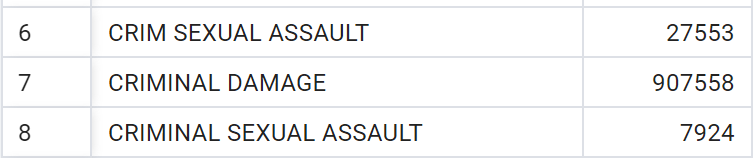

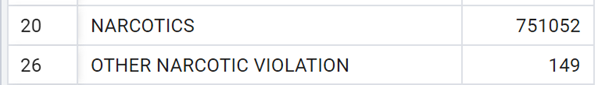

In [6]:
display(Image(filename="Screenshots/2.1_similar_types_1.png"))
display(Image(filename="Screenshots/2.1_similar_types_2.png"))

We will employ the following queries for grouping.

```sql
UPDATE crimes
SET primary_type = 'CRIMINAL SEXUAL ASSAULT'
WHERE primary_type = 'CRIM SEXUAL ASSAULT';

UPDATE crimes
SET primary_type = 'NARCOTICS'
WHERE primary_type = 'OTHER NARCOTIC VIOLATION';

```

Additionally, it is crucial to identify and eliminate non-criminal types from the dataset, given our focus on analyzing criminal data.

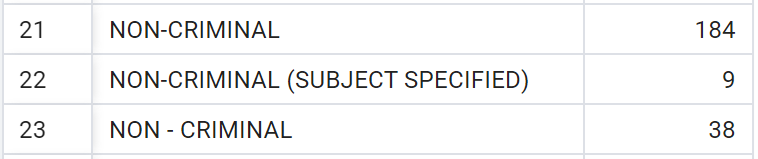

In [7]:
display(Image(filename="Screenshots/2.1_non-crimes.png"))

```sql
DELETE FROM crimes
WHERE primary_type IN ('NON-CRIMINAL', 'NON-CRIMINAL (SUBJECT SPECIFIED)', 'NON - CRIMINAL');
```

Furthermore, it is worth noting the existence of an uncommon crime type, represented by only one case among the eight million records.

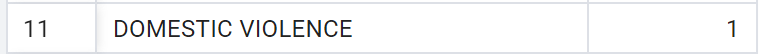

In [8]:
display(Image(filename="Screenshots/2.1_rare_types.png"))

Considering the dataset columns, the "Domestic" column specifically denotes whether an incident was domestic in nature or not. <br>
Given that this rare type lacks additional information and there is no evidence specifying the nature of the crimes, we reclassify this particular criminal type as "Others."

```sql
UPDATE crimes
SET primary_type = 'OTHER OFFENSE'
WHERE primary_type = 'DOMESTIC VIOLENCE';
```

We are left with 30 distinct crime types, posing a challenge for comprehensive visualization. To enhance clarity, we have manually classified the crimes into five classes:
- Property Offences
- Violent & Homicide
- Sexual Offences
- Disorderly Conduct
- Others

We will create a new table to store the classification shown below.

```sql
CREATE TABLE crime_class (
	primary_type VARCHAR(50) NOT NULL PRIMARY KEY,
	crime_class VARCHAR(50) NOT NULL
);
```

In [8]:
pd.read_csv('Crimes Classifications.csv')

,primary_type,class
0,ARSON,Property Offences
1,ASSAULT,Violent & Homicide
2,BATTERY,Violent & Homicide
3,BURGLARY,Property Offences
4,CONCEALED CARRY LICENSE VIOLATION,Violent & Homicide
5,CRIMINAL DAMAGE,Property Offences
6,CRIMINAL SEXUAL ASSAULT,Sexual Offences
7,CRIMINAL TRESPASS,Disorderly Conduct
8,DECEPTIVE PRACTICE,Property Offences
9,GAMBLING,Disorderly Conduct


We will insert a new column into the dataset, denoting the corresponding class for each crime.

```sql
ALTER TABLE crimes
ADD crime_class VARCHAR(50)

UPDATE crimes
SET crime_class = (
	SELECT crime_class.crime_class
	FROM crime_class
	WHERE crime_class.primary_type = crimes.primary_type
)
```

## 2.2: Districts as Crime Locations

Several columns within the dataset provide geographical information pertaining to the incidents, namely:
- Block
- Location Description
- Beat
- District
- Ward
- Community Area
- X & Y Coordinates
- Latitude & Longitude (Location)

Due to privacy considerations for crime victims, addresses are presented at the block level only, with coordinates, latitudes, and longitudes intentionally shifted. So, these columns will not be utilized to represent incident locations.

For the "Block" and "Location Description" columns, some records exhibit ambiguity and may not be suitable as reliable geographical classifiers.

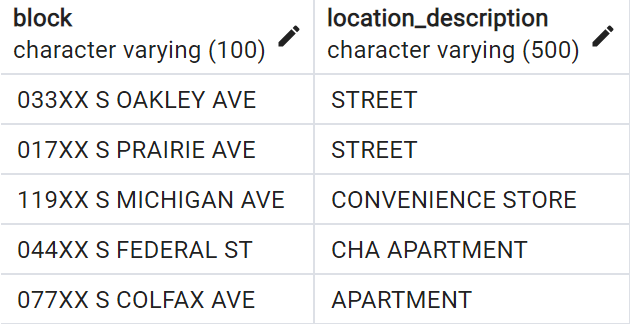

In [9]:
display(Image(filename="Screenshots/2.2_block_location_description.png"))

While the "Beat" column does not have null values and offers precision in classifying incident locations, the sheer volume of approximately 300 beats in Chicago presents challenges for effective visualization in the dashboard.

Hence, we have opted to employ the "District," "Ward," and "Community Area" columns as location classifiers.<br>
In this project, we specifically selected the "District" column for our incident location analysis due to its minimal null values. Any null values can be addressed by replacing them with the modal district of the corresponding beat, signifying the most frequently occurring district associated with the respective beat. <br>
Now, let's proceed to create a table dedicated to storing the modal district for each beat.

```sql
CREATE TABLE modal_district (
	beat VARCHAR(10) NOT NULL PRIMARY KEY,
	district VARCHAR(10) NOT NULL,
	freq bigint NOT NULL
);

INSERT INTO modal_district (
	WITH count_freq AS (
		SELECT 
			beat, 
			district,
			COUNT(district) AS freq,
			RANK() OVER (PARTITION BY beat ORDER BY COUNT(district) DESC) AS seq
		 FROM crimes
		 GROUP BY beat, district
		)
	SELECT
		beat, district, freq
	FROM count_freq
	WHERE seq = 1
);

SELECT *
FROM modal_district
LIMIT 5;
```

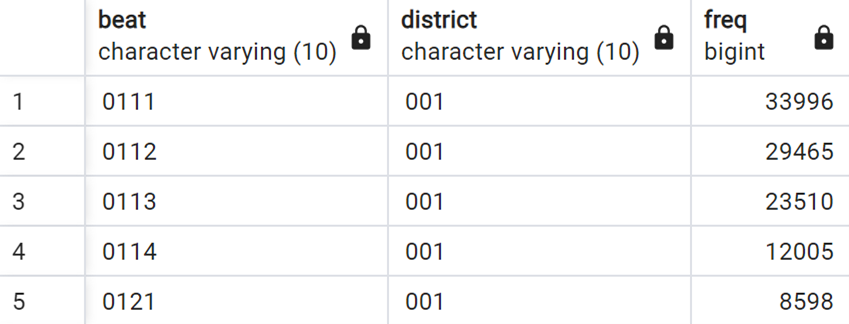

In [10]:
display(Image(filename="Screenshots/2.2_modal_district.png"))

To mitigate potential unforeseen circumstances during the dataset update process, we have implemented a precautionary measure by creating a Temp Table. This table serves as a pilot test on a one-year dataset, allowing us to safely fill in null values in the "District" column using the modal district.

```sql
DROP TABLE IF EXISTS temp_crimes;

CREATE TEMP TABLE temp_crimes (
	id BIGSERIAL NOT NULL PRIMARY KEY,
	case_no VARCHAR(10),
	crime_date TIMESTAMP ,
	block VARCHAR(100),
	iucr VARCHAR(10),
	primary_type VARCHAR(50),
	description VARCHAR(100),
	location_description VARCHAR(500),
	arrest BOOLEAN,
	domestic BOOLEAN,
	beat VARCHAR(10),
	district VARCHAR(10),
	ward VARCHAR(10),
	community_area VARCHAR(10),
	fbi_code VARCHAR(10),
	x_coord FLOAT(16),
	y_coord FLOAT(16),
	crime_year SMALLINT,
	updated_on TIMESTAMP,
	lat FLOAT(16),
	long FLOAT(16),
	loc VARCHAR(100)
);

INSERT INTO temp_crimes (
	SELECT *
	FROM crimes
	WHERE crime_year = 2008
);

SELECT id, beat, district, ward, crime_year
FROM temp_crimes
WHERE district IS NULL
ORDER BY id
LIMIT 5;
```

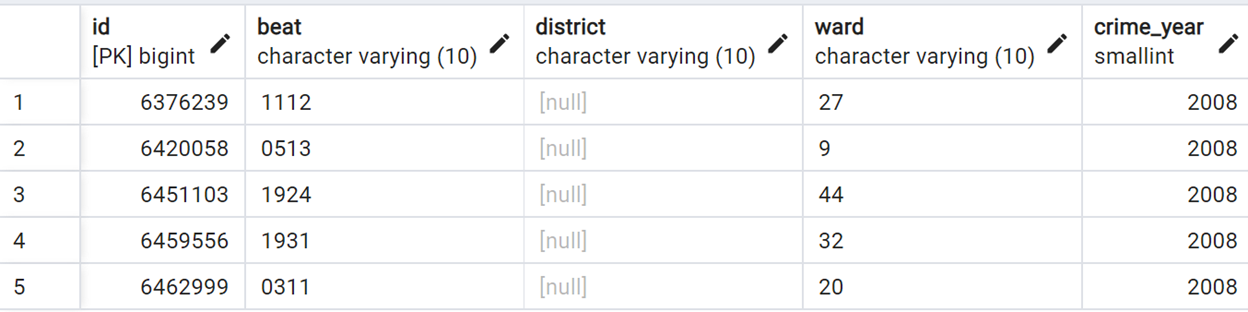

In [11]:
display(Image(filename="Screenshots/2.2_temp_table_before.png"))

Now, we will proceed to populate the null values in the "District" column of the Temp Table to assess whether the anticipated results are achieved.

```sql
UPDATE temp_crimes
SET district = (
	SELECT district
	FROM modal_district
	WHERE modal_district.beat = temp_crimes.beat
)
WHERE district IS NULL;

SELECT id, beat, district, ward, crime_year
FROM temp_crimes
WHERE id IN (6376239, 6420058, 6451103, 6459556, 6462999)
ORDER BY id;
```

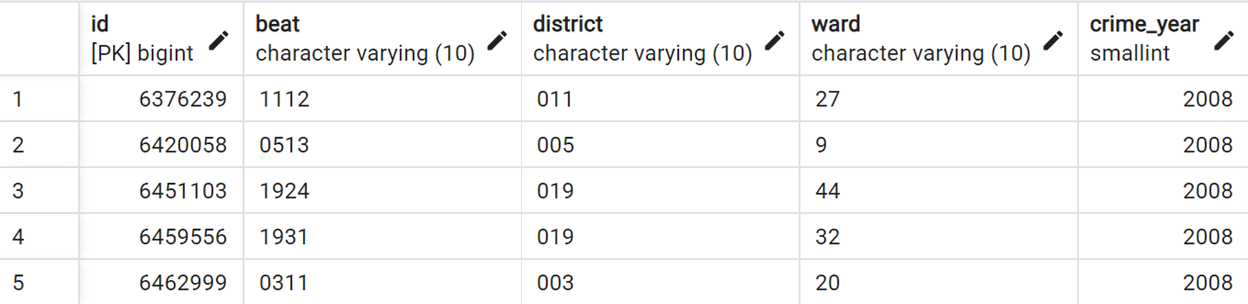

In [12]:
display(Image(filename="Screenshots/2.2_temp_table_after.png"))

With the queries yielding the expected results in the temporary table, we can confidently apply the same procedures to the entire dataset.

```sql
UPDATE crimes
SET district = (
	SELECT district
	FROM modal_district
	WHERE modal_district.beat = crimes.beat
)
WHERE district IS NULL;
```

To streamline the mapping relationships in the visualization stage using Power BI, it is necessary to remove the leading zeros in each district. Therefore, we will introduce an additional column, "dist_num," to facilitate this adjustment.

```sql
ALTER TABLE crimes
ADD dist_num VARCHAR(10);

UPDATE crimes
SET dist_num = (
	CASE
		WHEN SUBSTRING(district, 2, 1) = '0' THEN RIGHT(district, 1)
		ELSE RIGHT(district, 2)
	END
);
```

# 3: Exploratory Data Analysis

## 3.1: What were the numbers of crimes in each year?

```sql
SELECT crime_year, COUNT(*) AS total_crimes
FROM crimes
GROUP BY crime_year
HAVING crime_year % 4 = 0 --Records are displayed every 4 years
ORDER BY crime_year DESC
;
```

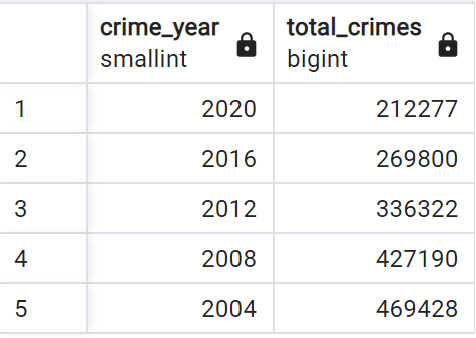

In [13]:
display(Image(filename="Screenshots/3.1_crimes_per_year.png"))

There has been a decreasing trend in the number of crimes in Chicago from 2001 to 2023.

## 3.2: What were the numbers of crimes in each month?

```sql
SELECT crime_month, freq
FROM (
	SELECT EXTRACT(MONTH FROM crime_date) AS crime_month, COUNT(*) AS freq
	FROM crimes
	GROUP BY crime_month
	)
WHERE crime_month % 2 = 0; --Records are displayed bimonthly
```

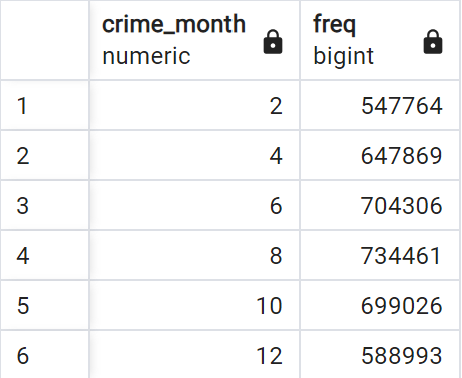

In [14]:
display(Image(filename="Screenshots/3.2_crimes_per_month.png"))

The number of crimes appears to exhibit a positive correlation with temperature, with more incidents occurring in summer and fewer in winter.

## 3.3: What were the arrest rates in each year?

```sql
WITH arrested AS (
	SELECT crime_year, arrest, CAST(COUNT(*) AS NUMERIC) AS arrested
	FROM crimes
	GROUP BY crime_year, arrest
	HAVING arrest = True
),
total AS (
	SELECT crime_year, CAST(COUNT(*) AS NUMERIC) AS total
	FROM crimes
	GROUP BY crime_year
)
SELECT
    total.crime_year,
    ROUND(arrested.arrested/total.total*100,2) AS arrested_rate
FROM arrested
INNER JOIN total ON arrested.crime_year=total.crime_year
WHERE total.crime_year % 4 = 0 --Records are displayed every 4 years
ORDER BY crime_year DESC
```

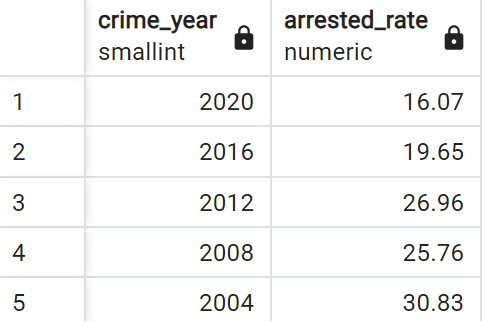

In [15]:
display(Image(filename="Screenshots/3.3_arrest_rate_per_year.png"))

The arrest rate also exhibits a decreasing trend from 2001 to 2023. One possible explanation for the lower arrest rates in recent years is that crimes from these years may still be under investigation.

## 3.4: What were the domestic crime rates in each year?

```sql
WITH domestic AS (
	SELECT crime_year, domestic, CAST(COUNT(*) AS NUMERIC) AS domestic_num
	FROM crimes
	GROUP BY crime_year, domestic
	HAVING domestic = True
),
total AS (
	SELECT crime_year, CAST(COUNT(*) AS NUMERIC) AS total
	FROM crimes
	GROUP BY crime_year
)
SELECT
	total.crime_year,
	ROUND(domestic.domestic_num/total.total*100,2) AS domestic_rate
FROM domestic
INNER JOIN total ON domestic.crime_year=total.crime_year
ORDER BY crime_year DESC
LIMIT 6;
```

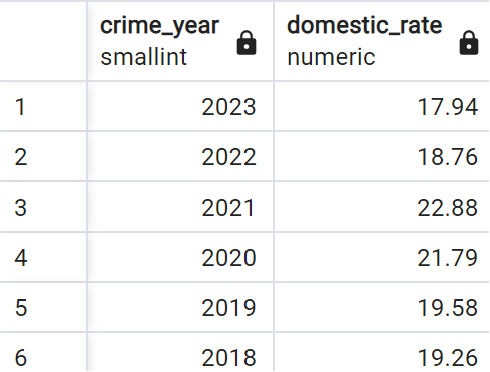

In [16]:
display(Image(filename="Screenshots/3.4_domestic_rate_per_year.png"))

The domestic crime rate exhibited a gradual increase from 2001 to 2019. However, during the pandemic years (2020 and 2021), there was a significant spike in the rate, followed by a subsequent decrease. <br> The observed fluctuations in the domestic crime rate during the pandemic and its subsequent decline may be attributed to the implementation of lockdown policies.

# 4: Dashboard

## 4.1: Design


The dashboard is divided into two pages, each dedicated to reporting temporal and geographic data. <br>
The temporal page presents crime rates by year on the left, alongside arrested rates and domestic rates. Meanwhile, on the right side, a horizontal bar chart illustrates the distribution of crimes across different months within a year, with crime types represented as the legend.

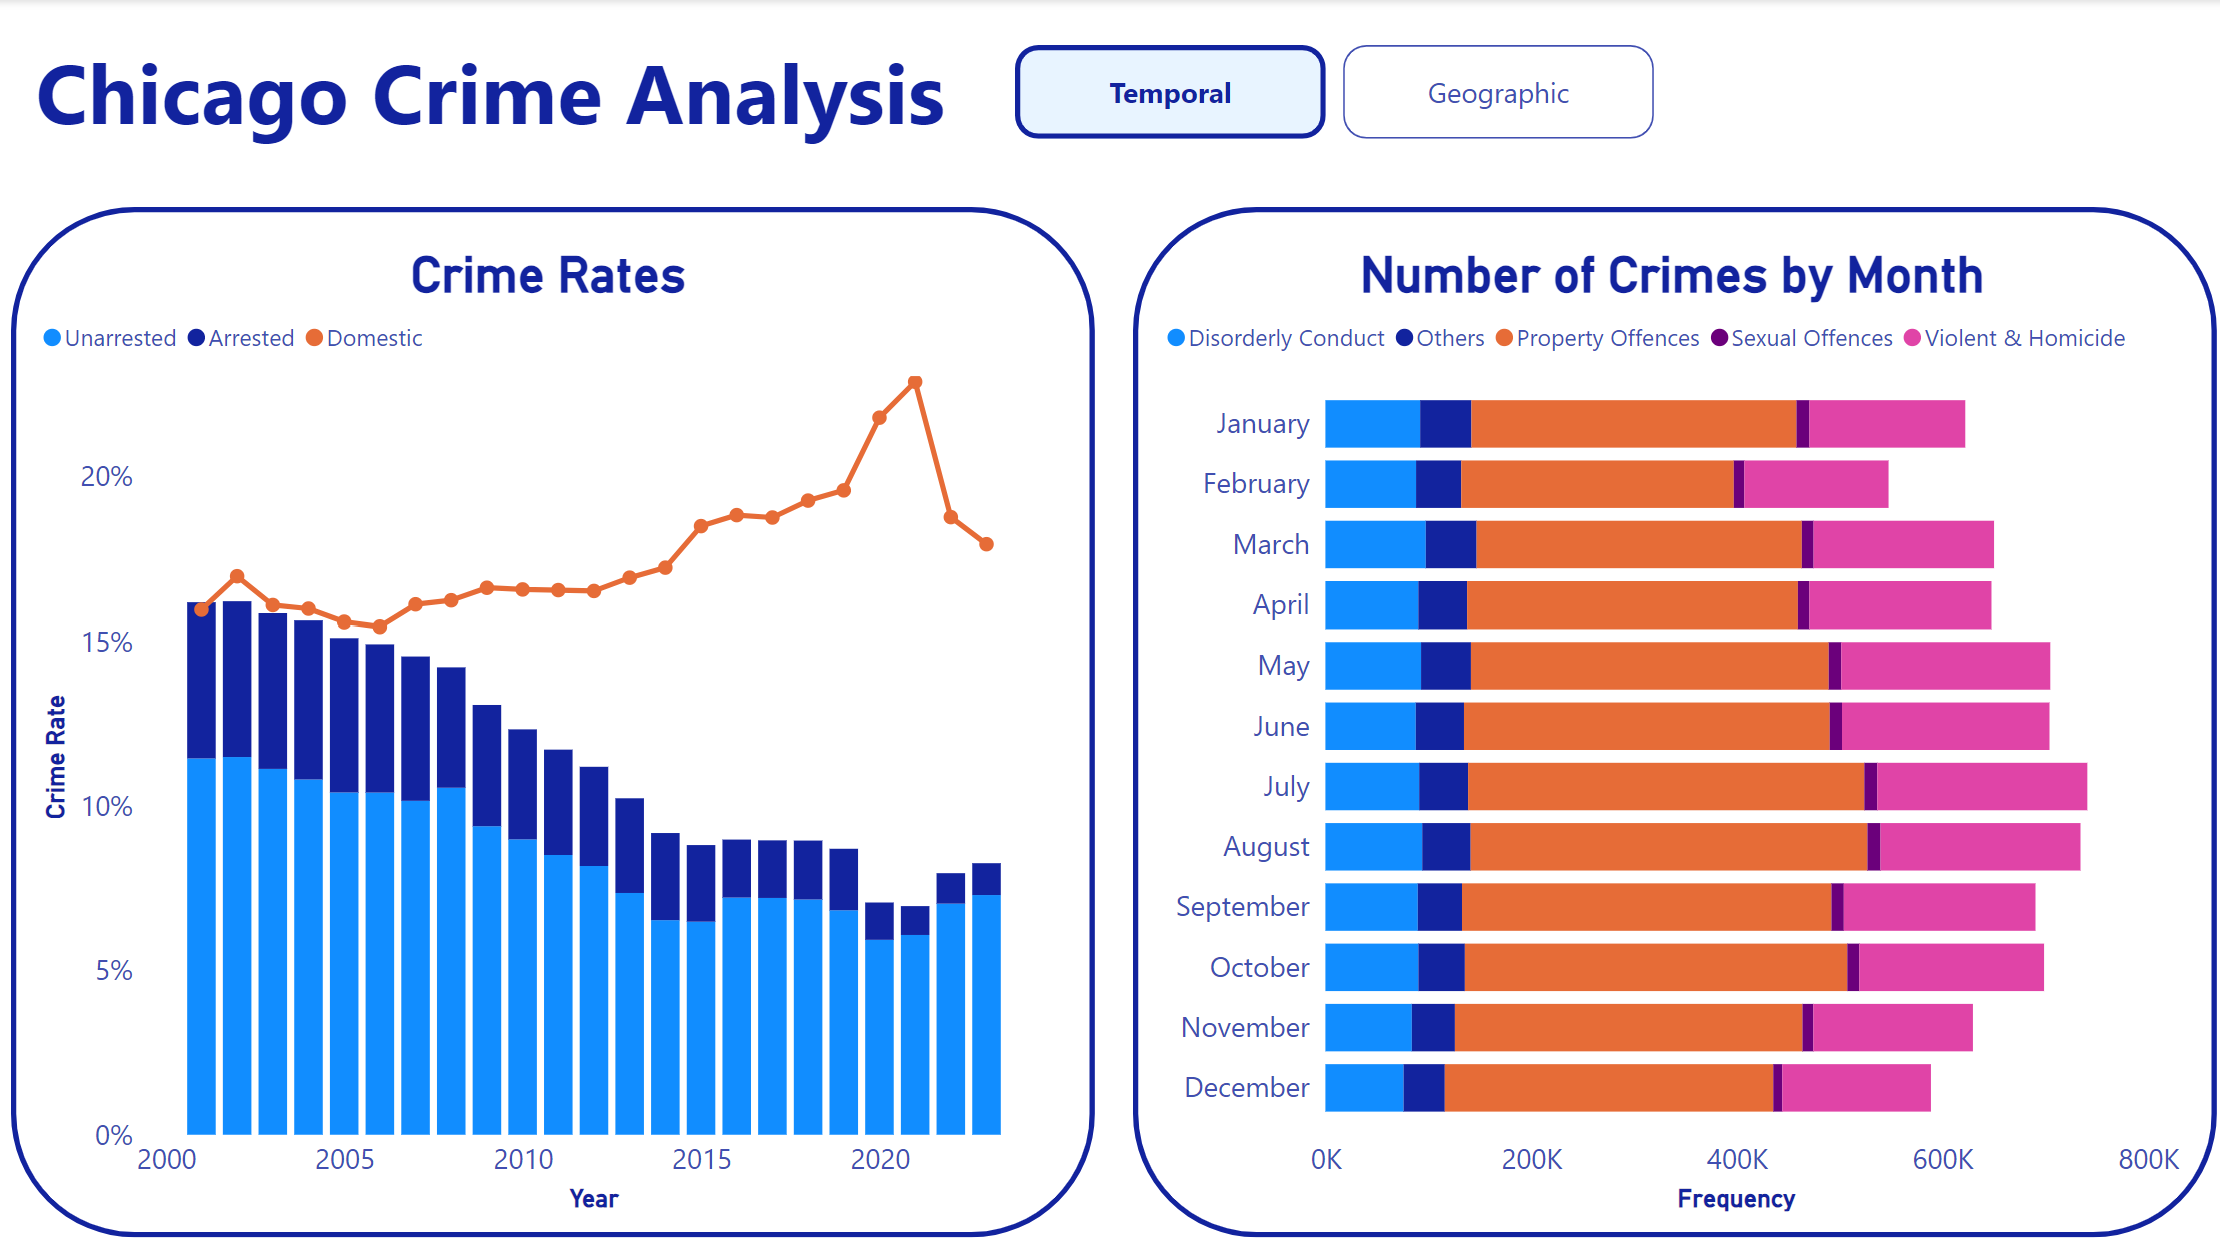

In [17]:
display(Image(filename="Screenshots/4.1_dashboard_1.png"))

The geographic page of the dashboard highlights the average crime rate for each police district, visually represented by color shading the region (green indicating low crime rates, while red indicates high crime rates). <br>
Positioned at the bottom right, three percentages are reported: average crime rate, average arrest rate, and average domestic crime rate. <br>
Additionally, user-input filters are incorporated to facilitate the selection of data within specific time ranges and crime types.

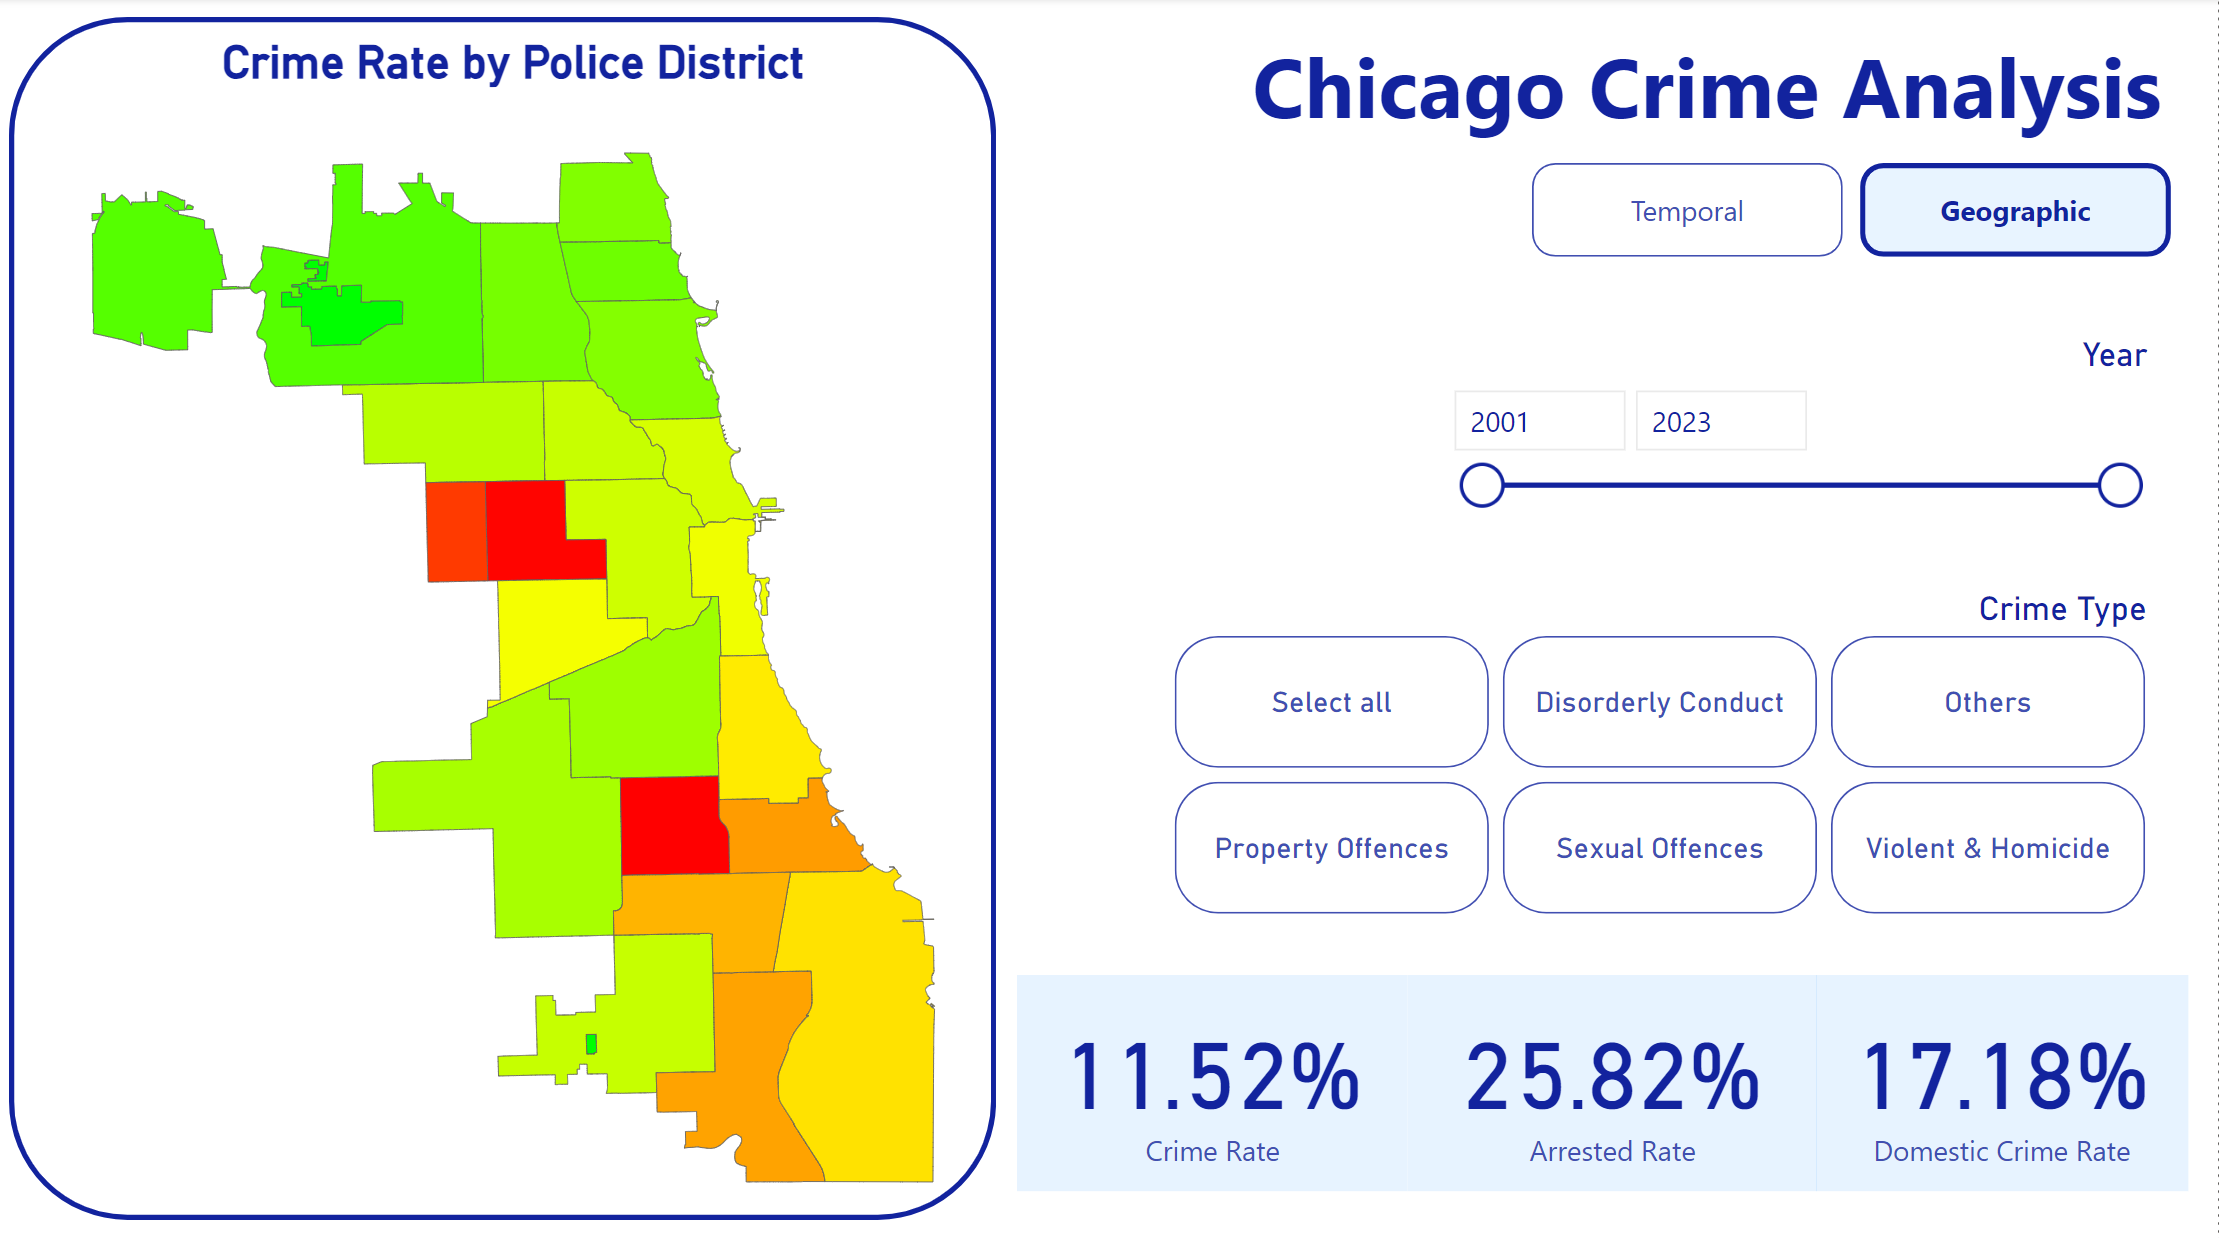

In [18]:
display(Image(filename="Screenshots/4.1_dashboard_2.png"))

Furthermore, when a user hovers over a particular district, a detailed report for that district is displayed. This report includes information such as the district's population, average number of crimes, crime rate, arrested rate, and domestic rate. The small blue bar within each gauge represents the average over the selected time period for the corresponding quantities.

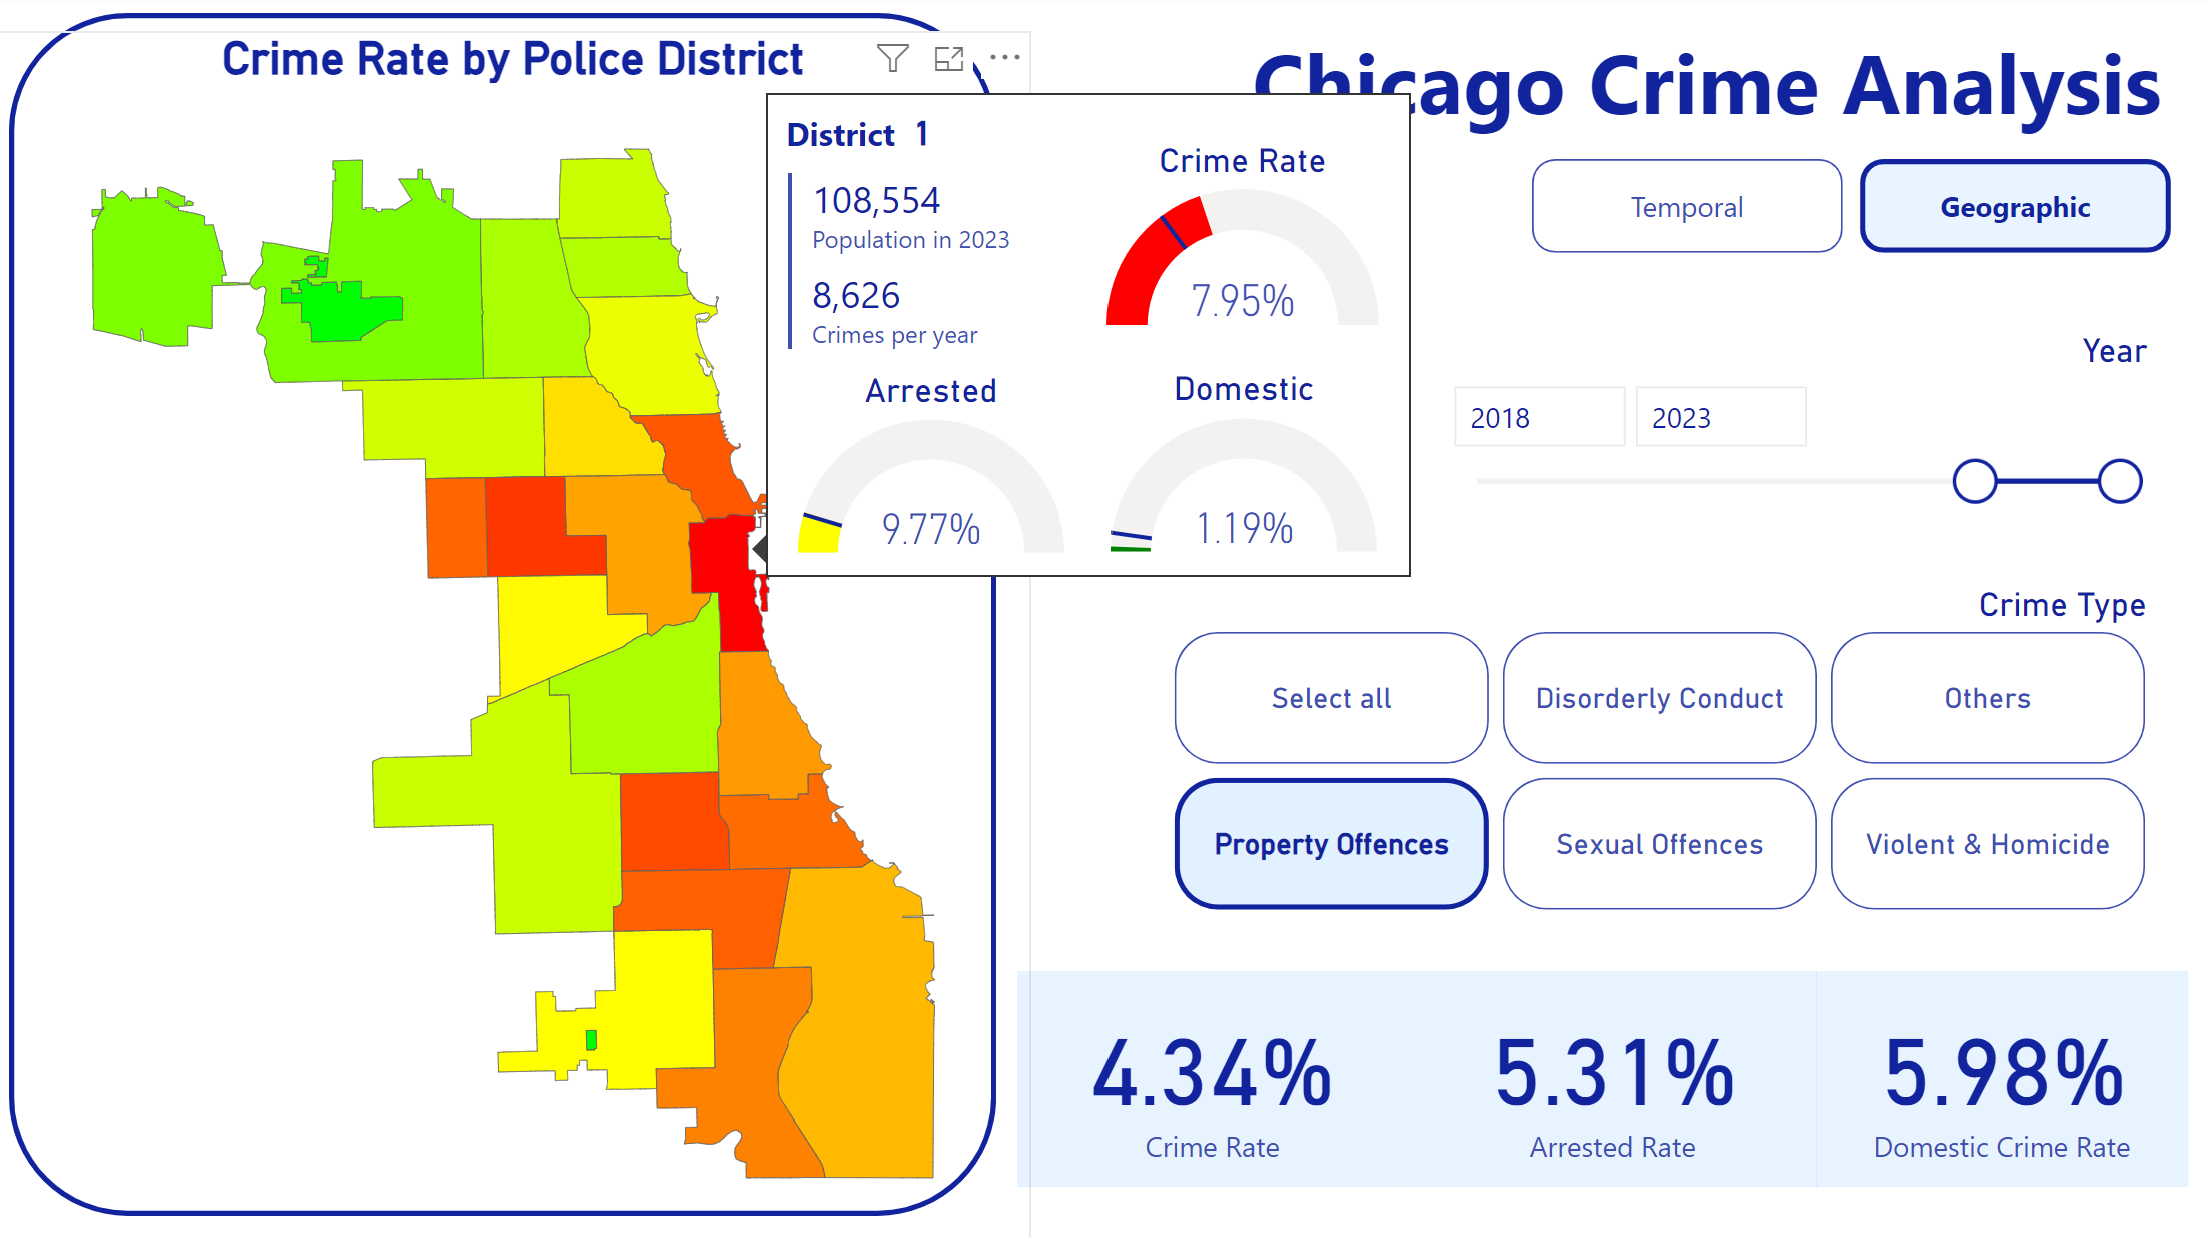

In [19]:
display(Image(filename="Screenshots/4.1_dashboard_3.png"))

## 4.2: Findings

### 4.2.1: Crime Rates over years

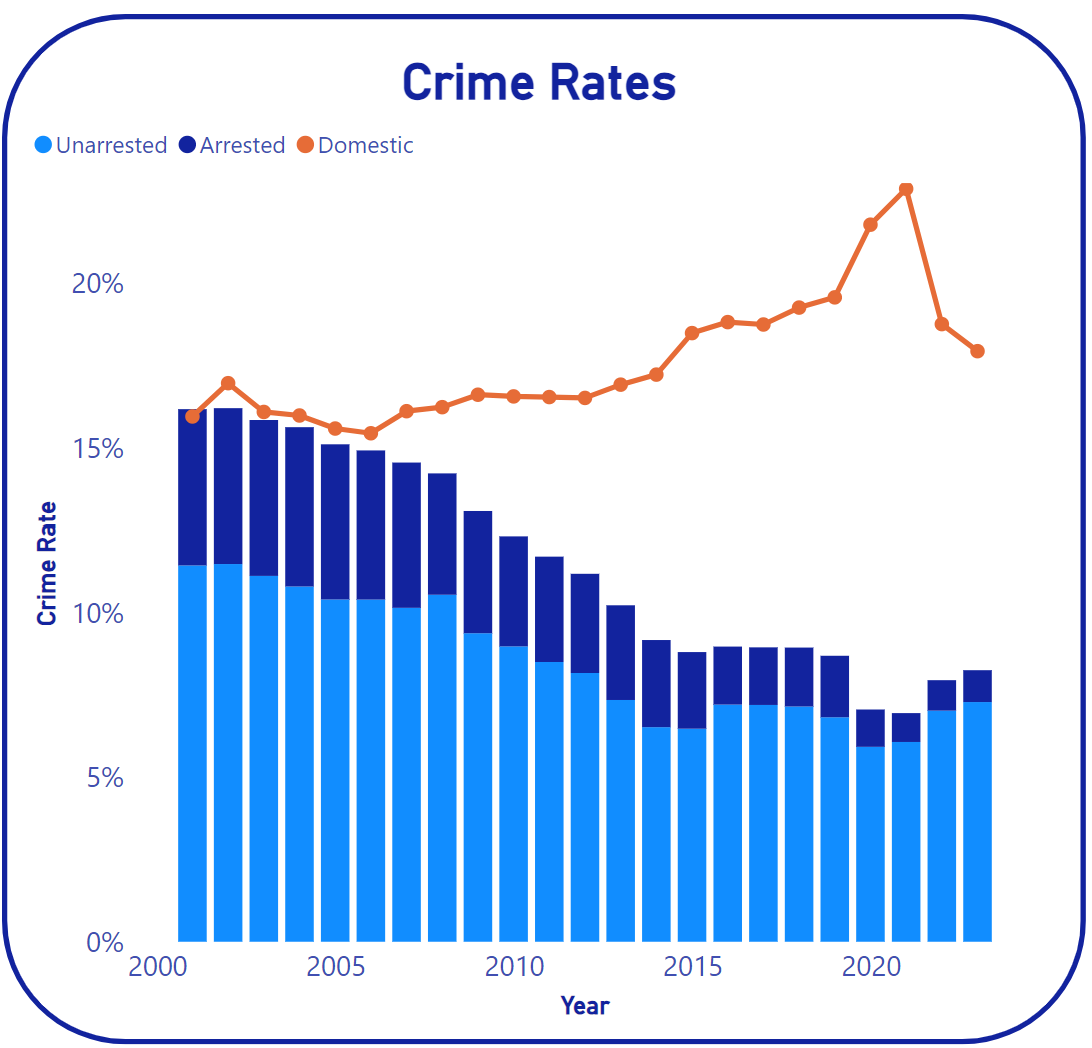

In [20]:
display(Image(filename="Screenshots/4.2.1_crime_rates.png"))

Reiterating the analysis from Section 3, the chart above visually depicts the trends observed in crime rates (comprising both arrested and unarrested incidents). Notably, the arrested rate exhibits a decreasing trajectory over the specified time period. Concurrently, domestic rates demonstrate a gradual increase, experiencing a notable spike during the COVID-19 period, followed by a subsequent decline.

### 4.2.2: Number of Crimes by Month

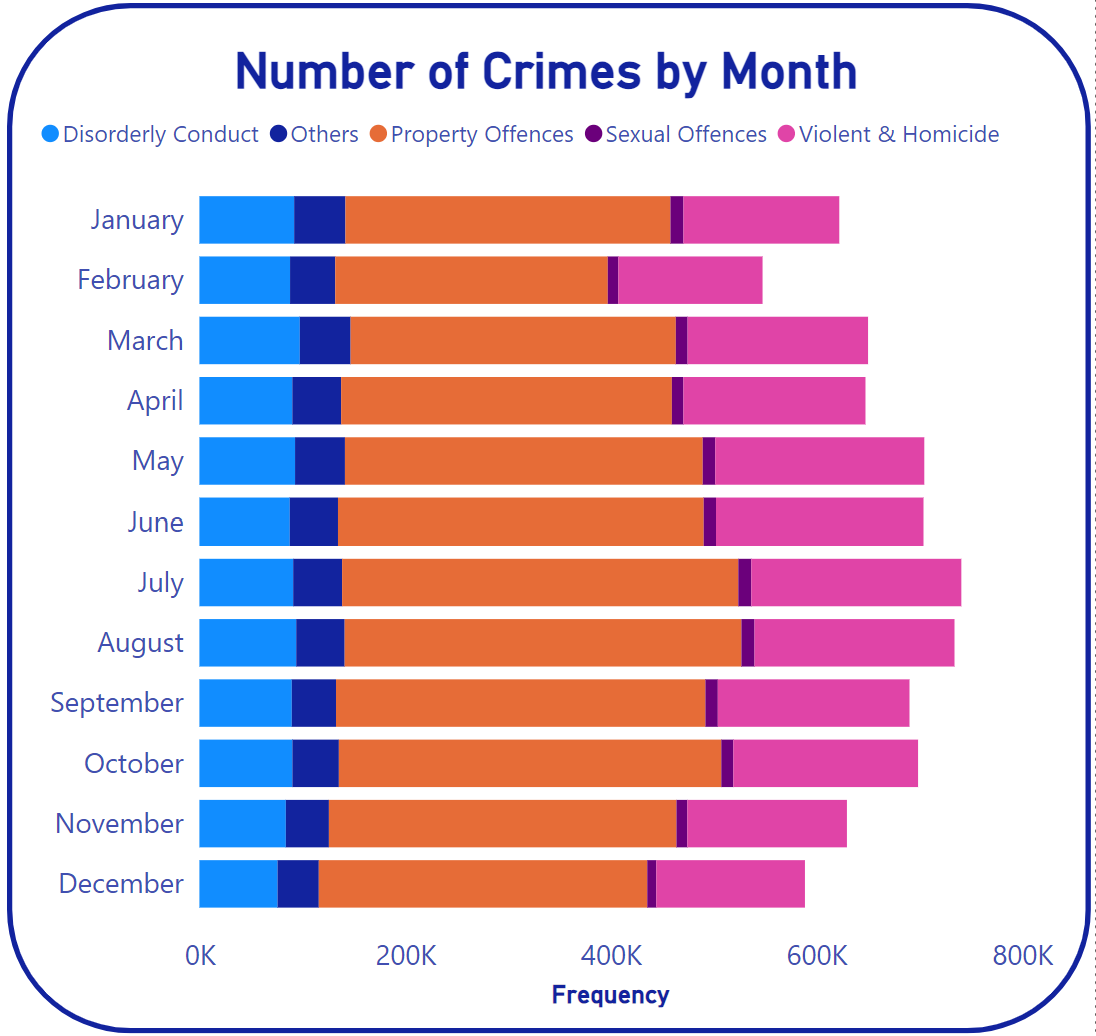

In [21]:
display(Image(filename="Screenshots/4.2.2_crimes_by_month.png"))

Similarly aligned with the insights presented in Section 3.2, the chart affirms that the number of crimes tends to decrease during the winter months (December to February), particularly for crimes associated with property offenses and violence. <br>
Moreover, it is evident that Property Offenses constitute the majority of reported crimes, whereas Sexual Offenses represent the least prevalent type of crimes in Chicago.

## 4.2.3: Crime Types by District

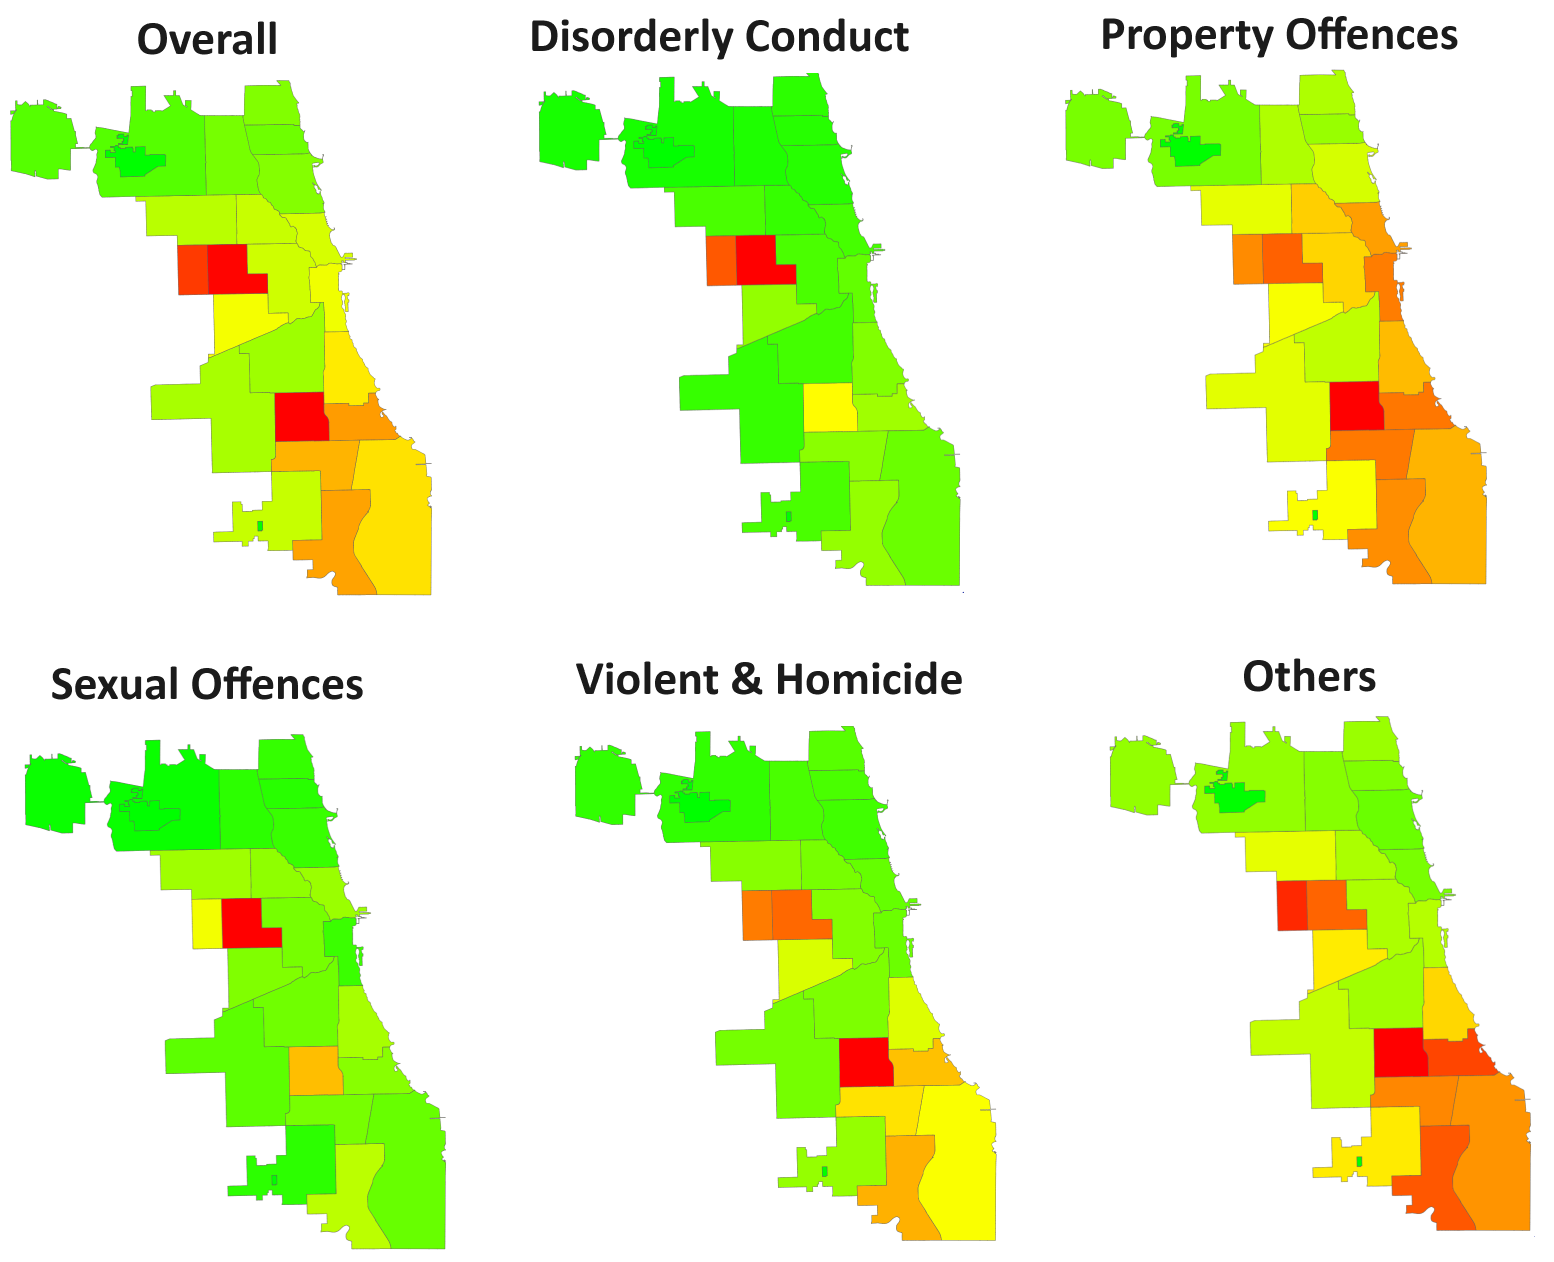

In [22]:
display(Image(filename="Screenshots/4.2.3_crime_type_by_district.png"))

Based on the presented figures, it is evident that crime rates in South-East Chicago are generally higher, while those in the North are comparatively lower. <br>
Specifically, the top three districts with the highest crime rates are Districts 7, 11, and 15, each exhibiting rates surpassing 24%. Notably, crimes categorized as Disorderly Conduct and Sexual Offenses are more likely to occur in these districts. <br>
Conversely, Districts 1, 18, and 19, situated in generally safer regions and proximity to the business center, demonstrate relatively higher crime rates in Property Offenses compared to other types of crimes.

# 5: Conclusion

In conclusion, this project analyzed Chicago Crime Data spanning from 2001 to 2023 and yielded the following key findings:
- The number of crimes and crime rates exhibit a decreasing trend over the years.
- Arrested rates show a consistent decline over the years.
- The domestic crime rate experiences an increase, particularly during the pandemic, followed by a subsequent decrease.
- Property Offense emerges as the most prevalent type of crime in Chicago.
- Crime rates tend to be lower during the winter months.
- North districts generally showcase lower crime rates compared to their counterparts in the South-East.
- Districts 7, 11, and 15 stand out with the highest crime rates.
- Property Offenses are more likely to occur in Center Chicago compared to other types of crimes.